# Group Project EDA
Author: John Thomas


## Dataset Intro

Our Dataset is  *Seattle Real Time Fire 911 Calls*, specifically the data from the calendar year of 2025 (00:01 on Jan 1, 2025
 to 24:00 on Dec 31, 2025.) This dataset details the time, location, and type of 911 calls assigned to the Seattle Fire Department, 
 and updates in near-realtime. The data can be viewed and queried [on the seattle open data website](https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj/data_preview)
but the specific subsection of data I'll be usig is available in the CSV in the data directory as the file `./data/real_time_fire_2025.csv`. 

## Stakeholder intro 
For our dataset, we have identified three stakeholders that would be making use of our developed visulaizations: 
- Emergency dispatch managers
- Seattle Fire Department Leadership
- City public safety planners (office of city council or mayor)

## Context 
These stakeholders are all fundamentally concerned with questions of resource allocation to best serve the people of this city, just at dramatically different scales.

 Dispatch leadership wants to be able to answer questions on a day to day operational level such as "How do we allocate calls between stations based on capacity?" - By using this data to map projected call volume at a given time (timeseries analysis) with the capacity of each station, you can minimize fire department response time to any particular call. 

 Fire Department Leadership has a similar problem but they want to be able to manage how to spread their capacity - "At what levels do we staff people at this time of year?" and "where should funds for growth go based on our capacity for the last year?" Knowing both in the short term seasonal sense where calls happen more lets them vary shifts appropriately, and forecasting what regions are more risk-prone or underserved for the volume of calls recieved lets them hire and expand appropriately. 

 City leadership concerned with this aspect of public safety are interested in what is happening where so they can budget and aquire funding appropriately. They're interestedin big picture - what kinds of problems are happening in the city? where are they happening? When combined with other datasets this can let them solve problems from multiple angles, but knowing where the literal fires are happning is the first step towards preventing them in the first place. 

In [1]:
# Setting up the environment and importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Part 1:
Loads and inspects the data, looking for data types, missing values, total size, column uniqueness, and outputting all of this
 (and any other data you feel relevant) to a cell.

In [2]:
# Load Data
data = pd.read_csv('./data/real_time_fire_2025.csv')
data.head()

,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number
0,Aurora Ave N / N 125th St,MVI Medic,2026 Jan 01 12:00:00 AM,47.719572,-122.344937,POINT (-122.344937 47.719572),F260000001
1,1333 Harbor Ave Sw,Illegal Burn,2025 Dec 31 11:59:00 PM,47.591918,-122.382656,POINT (-122.382656 47.591918),F260000002
2,3323 S Graham St,Aid Response,2025 Dec 31 11:57:00 PM,47.546103,-122.289056,POINT (-122.289056 47.546103),F250180050
3,81 CLAY ST,Ladder Code Red,2025 Dec 31 11:56:00 PM,47.615840,-122.352214,POINT (-122.352214 47.61584),F250180051
4,E Pine St / Boylston Ave,Aid Response,2025 Dec 31 11:55:00 PM,47.615231,-122.323415,POINT (-122.323415 47.615231),F250180049


In [3]:
display(data.shape)
data.info()
data.isnull().sum()

#notes: Datetime column needs to be converted to datetime format


(119301, 7)

<class 'pandas.DataFrame'>
RangeIndex: 119301 entries, 0 to 119300
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Address          119282 non-null  str    
 1   Type             119301 non-null  str    
 2   Datetime         119301 non-null  str    
 3   Latitude         119100 non-null  float64
 4   Longitude        119100 non-null  float64
 5   Report Location  119107 non-null  str    
 6   Incident Number  119301 non-null  str    
dtypes: float64(2), str(5)
memory usage: 6.4 MB


Address             19
Type                 0
Datetime             0
Latitude           201
Longitude          201
Report Location    194
Incident Number      0
dtype: int64

In [4]:
data.describe(include='string')

,Address,Type,Datetime,Report Location,Incident Number
count,119282,119301,119301,119107,119301
unique,34723,133,106630,28307,119301
top,1911 22nd Ave S,Aid Response,2025 Oct 28 01:23:00 PM,POINT (-122.304237 47.586234),F260000001
freq,536,57619,5,539,1


In [5]:
data.describe()

,Latitude,Longitude
count,119100.000000,119100.000000
mean,47.620851,-122.330345
std,0.053607,0.030309
min,47.293700,-122.435627
25%,47.594070,-122.347217
50%,47.613308,-122.328965
75%,47.661385,-122.312678
max,47.775757,-121.662787


## Parts 2 and 3
Cleans any invalid data (and documents what is being cleaned, why, and how).

Determines if there is missing data and what to do with any missing data.

*On Invalid Data:* We check for duplicates, but the overall hygene of this data is very high given the simplicity of it. We may choose to exclude some rows from our analysis later, such as calls that are immediately transfered to SPD, but that's easy to do later and I don't think benefits us at this time. 

In [6]:
# check for duplicates:
data.duplicated().sum()

np.int64(0)

In [7]:
#select rows with missing values in address column
missing_address = data[data['Address'].isnull()]
missing_address.head(20)

#check to see if there are rows with missing address values that have other location data (latitude and longitude)
missing_address_location = missing_address[missing_address['Latitude'].notnull() | missing_address['Longitude'].notnull()]
missing_address_location.head(20) #Note that this returns an empty dataframe

# I'm choosing to drop the rows with missing address values since they only account for 0.1% of the data 
# and we won't be able to use them to answer the questions that we have for our stakeholders in this project.
# I also note that the missing address colums aren't just missing the address, but rather any location data at all
data = data.dropna(subset=['Address'])

In [8]:
#select rows with missing values in location column
missing_location = data[data["Report Location"].isnull()]
missing_location.head(20)
# Since we already dropped the rows with missing address values, we can keep the ones with missing location values. 
# They're not as precise but should be useful

# I did notice that there are some rows that have a report location but no lat or long,
# which is interesting since the report location is just the lat and long as a tuple in most cases, so lets look a little closer at those rows
missing_lat_long = data[(data['Latitude'].isnull() | data['Longitude'].isnull()) & (data['Report Location'].notnull())]
missing_lat_long.head(20) 

# okay so we can fill these specific nulls with the report location data
data["Latitude"] = data["Latitude"].fillna(data["Report Location"].apply(
    lambda x: float(x.replace("POINT (", "").replace(")", "").split(' ')[1]) if pd.notnull(x) else np.nan)
    )

data["Longitude"] = data["Longitude"].fillna(data["Report Location"].apply(
    lambda x: float(x.replace("POINT (", "").replace(")", "").split(' ')[0]) if pd.notnull(x) else np.nan)
    )

## Part 4
Applies any data transformations, documenting the changes and why they are necessary.

In [9]:
# Convert the datetime column to datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.head()


/var/folders/0z/qzrdrqhx4zx_36rlcckyynh80000gn/T/ipykernel_80620/682170754.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Datetime'])


,Address,Type,Datetime,Latitude,Longitude,Report Location,Incident Number
0,Aurora Ave N / N 125th St,MVI Medic,2026-01-01 00:00:00,47.719572,-122.344937,POINT (-122.344937 47.719572),F260000001
1,1333 Harbor Ave Sw,Illegal Burn,2025-12-31 23:59:00,47.591918,-122.382656,POINT (-122.382656 47.591918),F260000002
2,3323 S Graham St,Aid Response,2025-12-31 23:57:00,47.546103,-122.289056,POINT (-122.289056 47.546103),F250180050
3,81 CLAY ST,Ladder Code Red,2025-12-31 23:56:00,47.615840,-122.352214,POINT (-122.352214 47.61584),F250180051
4,E Pine St / Boylston Ave,Aid Response,2025-12-31 23:55:00,47.615231,-122.323415,POINT (-122.323415 47.615231),F250180049


## Part 5
Drops any unnecessary columns and filters out any unnecessary rows, documenting reasons for these decisions. Choosing not to drop columns or filter any data is also valid but should be documented and supported.

I'm choosing not to filter any rows at this time. I suspect that there will be certain kinds of calls that we will choose to filter out in the future, but since call type analysis is a major part of this I don't feel right excluding any of them at this time. 

We will however be getting rid of the Report location column just for data cleanliness purposes. It doesn't have any data that isn't found in a more useful format in the Lat and Lon columns

In [ ]:
# Drop column Report Location, since it's redundant 
# lmao I take it back this isn't redundant, it's just GIS formating.
# actually geopandas hates it
data = data.drop(columns=['Report Location'])

#save data to a new csv file
data.to_csv('./data/cleaned_real_time_fire_2025.csv', index=False)

## Part 6
Identifies relevant dependent variables for analysis and plots distributions. Documents why the dependent variables were chosen.


It doesn't feel particularly statistically correct to call any of this really the dependent variable. I think the best thing for us to do in the long run is to develop some aggregate measures, like a grid system, and predict the number of calls in a given grid cell in a particular time. 

That being said, for the purposes of argument here and an initial exploration, the call type would be the most likely dependent variable at this time. 


In [11]:
call_counts = data["Type"].value_counts()
display(call_counts)

top_call_counts = call_counts[:20]

Type
Aid Response                     57619
Medic Response                   10784
Auto Fire Alarm                   7053
Aid Response Yellow               4748
Triaged Incident                  3646
                                 ...  
Tunnel Car Fire                      1
Rescue Confined Space                1
Tunnel Rescue Standby                1
BC Medic Response- 7 per Rule        1
Train Derailment wFireHzmt           1
Name: count, Length: 131, dtype: int64

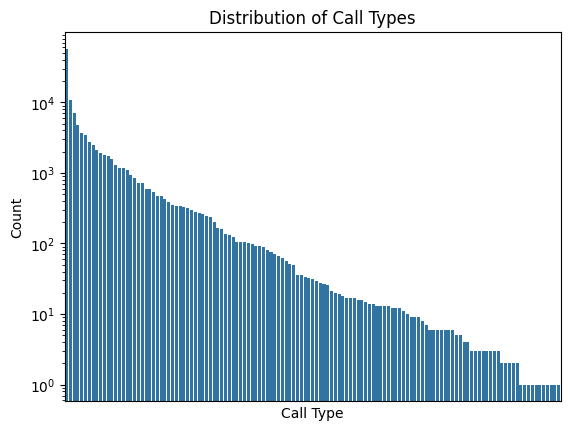

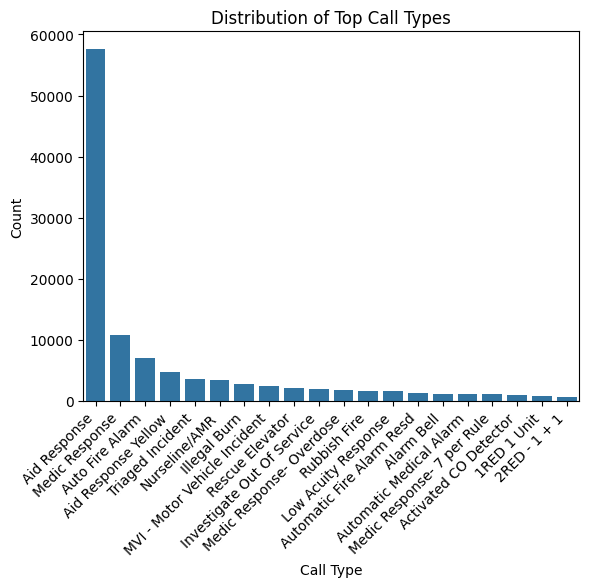

In [12]:
# plot the distribution of the different types of calls in the data
sns.countplot(data=data, x='Type', order = call_counts.index)
plt.xticks(ticks=[])
plt.title('Distribution of Call Types')
plt.xlabel('Call Type')
plt.ylabel('Count')
plt.yscale("log")
plt.show()

# we can see that there's a pretty aggressive exponential distribution here, and using a logarithmic scale on the y axis makes this clear
# to get some more fidelity, let's look at the top 20 more closely:

top_categories = data[data["Type"].isin(top_call_counts.index.tolist())]

sns.countplot(data=top_categories, x="Type", order=top_call_counts.index)
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Top Call Types")
plt.xlabel("Call Type")
plt.ylabel('Count')
plt.show()

## Part 7
Identifies any outliers in the data using both descriptive statistics and a box plot. If outliers exist, explain what approach (if any) you will take to deal with them and then implement said approach.

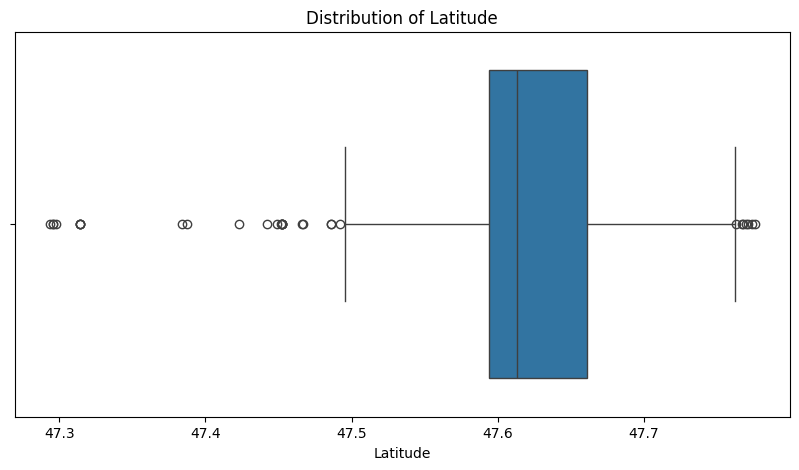

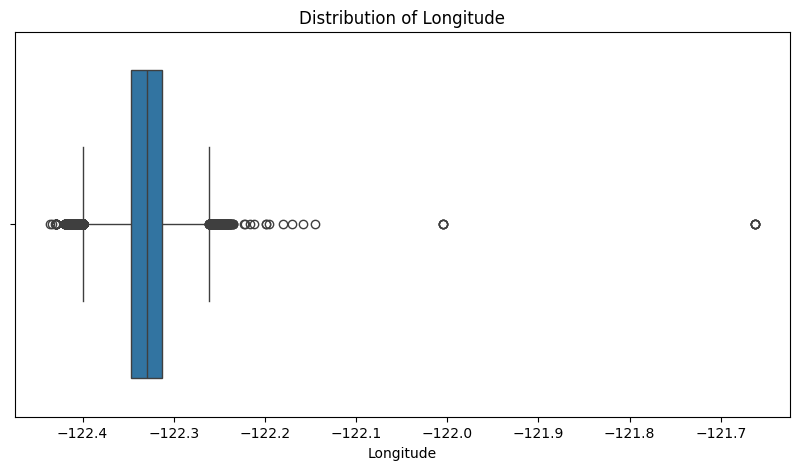

In [13]:
# Graph Distribution of Lat and Long using box plots to check for outliers,
#  since it should be in seattle this should be a narrow range
plt.figure(figsize=(10,5))
sns.boxplot(x='Latitude', data=data)
plt.title('Distribution of Latitude')
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(x='Longitude', data=data)
plt.title('Distribution of Longitude')
plt.show()


# there are definitely some outliers in this, but until I teach myself Geospatial analysis, it's impossible to know what is 
# and isn't an outlier, so we're going to choose not to remove anything at this time.

## Part 8
Identify any possible correlations or relationships. Document how you found them, if they are significant, and why they matter (or why not). At least one method of verifying (positively or negatively) a correlation or relationship should involve a data visualization

## Discussion
I'm going to be real here, any actually interesting correlations are going to be locked behind geospatial analysis and need some fairly heavy augmentation for this data, such as neighborhood, or other geofencing, or more nuanced timeseries analysis. 

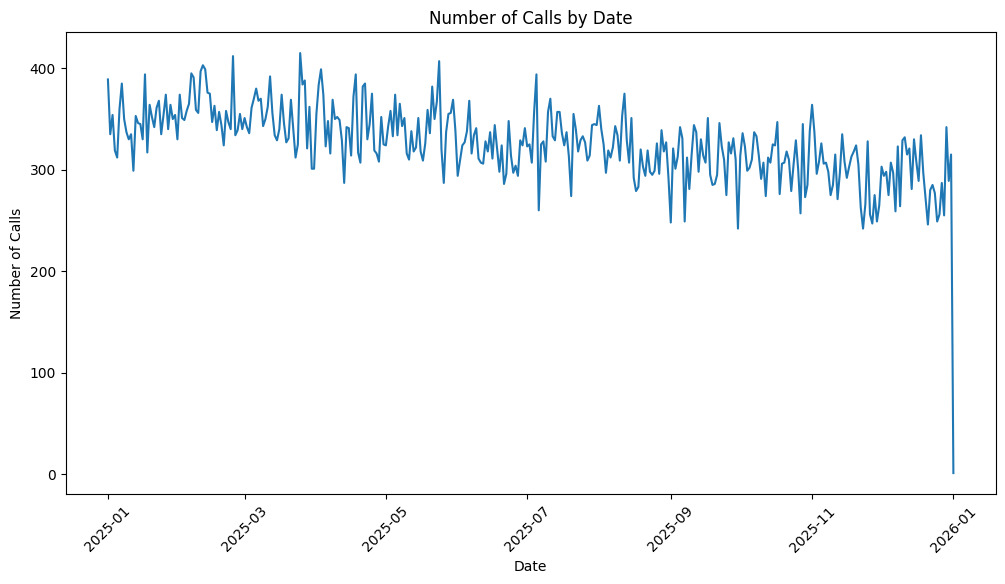

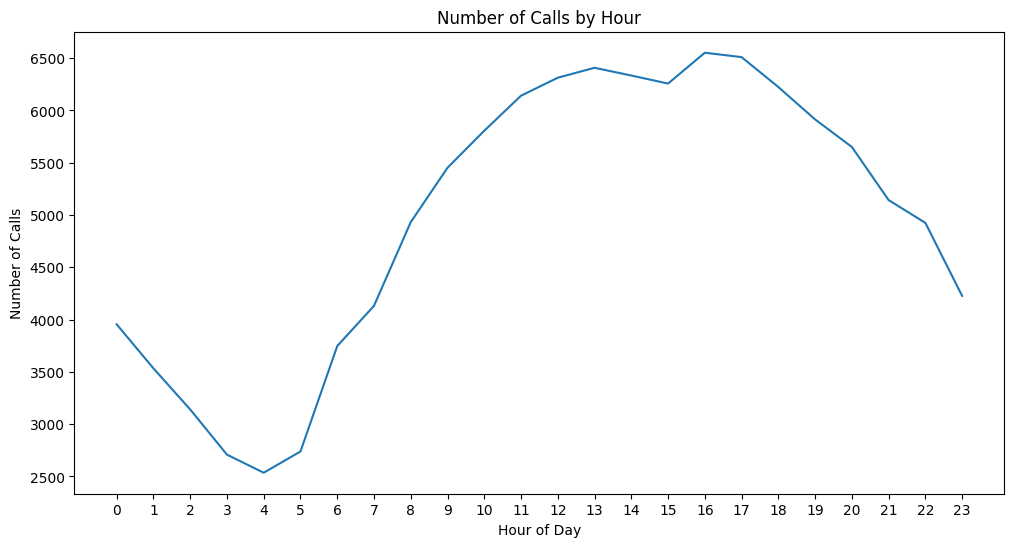

In [14]:
# plot number of calls versus date and time to look for trends:
data['Date'] = data['Datetime'].dt.date
data['Hour'] = data['Datetime'].dt.hour 
calls_by_date = data.groupby('Date').size()
calls_by_hour = data.groupby('Hour').size()

# calls by date
plt.figure(figsize=(12,6))
sns.lineplot(x=calls_by_date.index, y=calls_by_date.values)
plt.title('Number of Calls by Date')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.show()        

# calls by hour 
plt.figure(figsize=(12,6))
sns.lineplot(x=calls_by_hour.index, y=calls_by_hour.values)
plt.title('Number of Calls by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Calls')
plt.xticks(range(0,24))
plt.show()

# Summarize My Findings

So, my first impressions for this dataset are that it's a ton of information about a VERY specific domain. There are absolutely interesting insights in this data, but it'll require some understanding of Geospatial analysis and a review of my frequentist timeseries analysis methods. 

### Is the dataset sufficient to answer the stakeholders questions or does it need to be enriched?
I think that while it could be sufficient to answer many of them, there is quite a bit of enrichment that it would benefit from. One of the major things that needs to be done is to go through the definitions of each of the types of calls and make general category terms for them - things like "Fire" or "medical" etc so that we can see larger-scale trends. The two most common calls are "simple medical" and "advanced medical" essentially, and those could be lumped for initial plotting, and the nuance made available for drill-down. 

New data we need:
- Finding formal definitions for each code will be key
- Addresses of fire stations 

Other things that could be telling if we have the time or inclination: 
- Demographics or Census Data
- Weather data

### What do you suggest the team should look for in terms of mining the data?
Overall I think we're looking for how far frequentist methods can take us in terms of building predictions out for when things might happen. The biggest thing we'll need to do is split the dataset into chunks by type and begin looking for patterns this way. This might be a great usecase for a decision tree. 

### What is the story you think the team should be telling?
I think a major story here is that the VAST majority of fire department calls are actually medical calls. by a huge majority. Exploring that more and interrogating the difference in patterns between medical needs of a community (eg. basic medical care to trauma calls) and fire / rescue needs of a community (eg. fires, hazmat), and the stuff that's both (eg. car crashes). 

### What are your recommendations for the various dashboard models?
Maps are unavoidable here, but I think having a call frequency KPI for each georegion we define and a for each major type cluster will be beneficial as well. 

### Reflection:
#### Do you feel you have a better understanding of the dataset now?
 I think I'm beginning to. I didn't want to have to explore mapping for this EDA, so much of what I could do was limited, but I feel MUCH more comfortable with what has to happen next and where we might want to begin. I think there's some nice concrete action items on both the data structures side and the software side. 

#### Do you feel better prepared to work with your teammates to make a dashboard of this data?
I do! I think as I mentioned above that we have actually a good surface area to begin digging into these things, and the process of getting there will be one that's both educational and iterative. 




